In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from time import time
import matplotlib
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
from sklearn.decomposition import PCA
tf.keras.backend.set_floatx('float64')
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
%matplotlib inline
print("tensorflow version: ", tf.__version__)
print("numpy version: ", np.__version__)
print("matplotlib version: ", matplotlib.__version__)
print("sklearn version: ", sklearn.__version__)

tensorflow version:  2.2.0
numpy version:  1.18.1
matplotlib version:  3.1.1
sklearn version:  0.21.3


<center> <h1> Creating the utils for the project</h1>

<b>Autor:</b> Edwin Rueda <br>
<b>email:</b> ejrueda95g@gmail.com <br>
<b>github:</b> https://github.com/ejrueda <br>
<b>website:</b> http://edwinrueda.com/ <br>
<b> You can cite this work with</b>:

@software{edwin_rueda_2020_3843381,<br>
  author       = {Edwin Rueda},<br>
  title        = {ejrueda/MasterUFPA: zenodo release},<br>
  month        = may,<br>
  year         = 2020,<br>
  publisher    = {Zenodo},<br>
  version      = {zenodo},<br>
  doi          = {10.5281/zenodo.3843381},<br>
  url          = {https://doi.org/10.5281/zenodo.3843381}<br>
}

### scaler
- The scaler class make a minmaxscaler operation in a dataframe, this allows that the dataframe keep your index.
- Parameters:
    - xmin: the min value of the scale
    - xmax: the max value of the scale
- Equation:
    - this scaling is computed by:
$$X_{new} = \frac{x-min(x)}{max(x) - min(x)} *(x_{max}-x_{min}) + x_{min}$$      

    where $x$ represents the dataframe, and $min(x)$ and $max(x)$, represents the minimum and maximum values per column in the dataframe.

In [2]:
class scaler:
    def __init__(self, xmin, xmax):
        """
        minmax scaler from dataframe
        """
        self.xmin = xmin
        self.xmax = xmax
        self.min_data = False
        self.max_data = False
        self.flag = False
        
    def fit(self, X):
        self.min_data = np.min(X).values
        self.max_data = np.max(X).values
        self.flag = True
        
    def transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler, called .fit()"
        X_r = X.copy()
        X_r = ((X_r - self.min_data)/(self.max_data - self.min_data))*(self.xmax-self.xmin) + self.xmin
        return X_r
    
    def inverse_transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler, called .fit()"
        X_r = X.copy()
        X_r = ((X_r - self.xmin)*(self.max_data - self.min_data)/(self.xmax - self.xmin)) + self.min_data
        return X_r

### Gan utils
- Gan utils is the class to create, train and evaluate the performance of a GAN architecture.

- Functions:
    - <b>kl_divergence:</b> compute the Kullback-Leibler divergence of the Discriminator network.
        - <b>parameters:</b>
            - <b>probability:</b> the probability of the discriminator network.
    - <b>train_gan:</b> this fuction combine the generator and discriminator networks and train the gan architecture. Note that this utils implements the tensorflow library, therefore, the G and D networks are not compiled, you just have to pass the networks without compile.
        - <b>parameters:</b>
            - <b>dataset:</b> a dataset to train the gan architecture, must be a tensorflow dataset.
            - <b>G:</b> generator model without training.
            - <b>D:</b> discriminator model without training.
            - <b>epochs:</b> number of epochs to train de gan architecture.
            - <b>batch_size:</b> the size of the batch to train de gan architecture.
            - <b>loss_function:</b> the loss funtion, in this case, this architecture must employ the binary_cross_entropy loss function.
        - <b>return:</b>
            - <b>accumulated_g_loss:</b> the generator loss by epochs in the architecture.
            - <b>accumulated_d_loss:</b> the discriminator loss by epochs in the architecture.
    - <b>train_step:</b> this function train the architecture over one batch. Note that this function is a tensorflow function.
        - <b>parameters:</b>
            - <b>sample:</b> batch to train the architecture. this batch must be a tensorflow batch.
            - <b>batch_size:</b> the size of the batch to train the architecture.
            - <b>loss_function:</b> the loss function of the architecture. Note that in these architectures, the loss function must be a binary_cross_entropy function.
            - <b>noise_input:</b> the size of the noise vector to train de generator network. In this approach, the noise vector is based in a normal distribution $N(0,1)$.
        - <b>return:</b>
            - <b>gen_loss:</b> the batch loss in the generator network.
            - <b>dis_loss:</b> the batch loss in the discriminator network.
    - <b>plot_results:</b> this function plots four different figures. 1) the cost function of the arquitecture. 2) the kullback-leibler divergence. 3) the precision of the D network. 4) the 2-PCA representation of the synthetic samples.
        - <b>parameters:</b>
            - <b>syn_size:</b> the number of synthetic samples to be generated.
        - <b>return:</b> 
            - <b>p:</b> plot containing the four figures.

In [28]:
class gan_utils:
    
    def __init__(self):
        self.accumulated_gloss = []
        self.accumulated_dloss = []
        self.precision = []
        self.recall = []
        self.kl_d = []
        self.X_train = None
        self.G = None
        self.D = None
        self.noise_input = None
    
    @tf.function
    def kl_divergence(self, probability):
        probability = tf.clip_by_value(probability, 1e-5, 1-1e-5)
        return tf.reduce_mean(probability*tf.math.log(probability/(1-probability)))
    
    @tf.function
    def binary_cross_entropy(self, prediction, target):
        """
        compute the loss for binary clasification problems
        """
        prediction = tf.clip_by_value(prediction, 1e-5, 1-1e-5)
        return -tf.reduce_mean(target*tf.math.log(prediction) + (1-target)*tf.math.log(1-prediction))

    @tf.function
    def train_step(self, sample, batch_size, noise_input, optimizerG, optimizerD):
        noise = tf.random.normal([batch_size, noise_input])
        with tf.GradientTape() as gG, tf.GradientTape() as gD:
            synthetic_data = self.G(noise, training=True)

            real_output = self.D(sample, training=True)
            fake_output = self.D(synthetic_data, training=True)

            gen_loss = self.binary_cross_entropy(fake_output, tf.ones_like(fake_output))
            dis_loss = .5*(self.binary_cross_entropy(real_output, tf.ones_like(real_output)) + self.binary_cross_entropy(fake_output,tf.zeros_like(fake_output)))

        g_generator = gG.gradient(gen_loss, self.G.trainable_variables)
        g_discriminator = gD.gradient(dis_loss, self.D.trainable_variables)

        optimizerG.apply_gradients(zip(g_generator, self.G.trainable_variables))
        optimizerD.apply_gradients(zip(g_discriminator, self.D.trainable_variables))

        return gen_loss, dis_loss
    
    def train(self, dataset, G, D, noise_input, epochs, batch_size, optimizerG, optimizerD):
        #reset metrics
        self.accumulated_gloss = []
        self.accumulated_dloss = []
        self.precision = []
        self.recall = []
        self.kld = []
        batch_g_loss = []
        batch_d_loss = []
        self.G, self.D = G, D
        self.noise_input = noise_input
        self.X_train = dataset
        batches = tf.data.Dataset.from_tensor_slices(dataset).batch(batch_size)
        for epoch in range(epochs):
            t_i = time()
            for batch in batches:
                batch_g_loss, batch_d_loss = self.train_step(batch, batch_size, noise_input,
                                                             optimizerG, optimizerD)
            self.accumulated_dloss.append(tf.reduce_mean(batch_d_loss))
            self.accumulated_gloss.append(tf.reduce_mean(batch_g_loss))

            X_sint = G(tf.random_normal_initializer(mean=0.0, stddev=1)([batch_size,noise_input],
                                                                        dtype=tf.float64))
            X_comb = tf.concat([dataset, X_sint], axis=0)
            y_comb = tf.concat([tf.ones((dataset.shape[0],1)), np.zeros((X_sint.shape[0],1))], axis=0)
            y_proba = D(X_comb)
            y_predict = tf.reshape((tf.greater(y_proba, .5).numpy()*1), [-1])
            self.kl_d.append(self.kl_divergence(y_proba).numpy())
            self.precision.append(precision_score(y_comb.numpy(), y_predict.numpy()))
            self.recall.append(recall_score(y_comb.numpy(), y_predict.numpy()))
            t_f = time()
            
            print("epochs[%d:%d] :: G_loss[%f] :: D_loss[%f] :: time:%f[s]"%(epoch, epochs,
                                                                             self.accumulated_gloss[-1],
                                                                             self.accumulated_dloss[-1],
                                                                             t_f-t_i))
        return self.accumulated_gloss, self.accumulated_dloss
        
    def plot_results(self, syn_size):
        fig = plt.figure(figsize=(15,10))
        for i in range(4):
            plt.subplot(2,2, i+1)
            if i==0:
                rr = range(0,len(self.accumulated_gloss), 3)
                short_g_loss = [self.accumulated_gloss[i] for i in rr]
                short_d_loss = [self.accumulated_dloss[i] for i in rr]
                plt.plot(rr, short_g_loss, label="Generator", color="#FFB248")
                plt.plot(rr, short_d_loss, label="Discriminator", color="#5F84B4")
                plt.xlabel("Epochs", fontsize=13)
                plt.ylabel("Loss", fontsize=13)
                plt.grid(axis="y")
                plt.legend();
            elif i==1:
                plt.title("Divergencia de Kullback-Leibler", fontsize=14)
                plt.plot(range(len(self.kl_d)), self.kl_d, linewidth=.5)
                plt.plot(range(len(self.kl_d)), np.zeros(len(self.kl_d)))
                plt.grid()
                plt.xlabel("Epochs");
                plt.ylabel("Divergencia de Kullback-Leibler");
            elif i==2:
                short_precision = [self.precision[v] for v in rr]
                plt.plot(rr, short_precision, linewidth=.8, label="precision")
                plt.grid(axis="y")
                plt.plot(rr, np.ones(len(short_precision))*.5,
                         label="target", linestyle="--")
                plt.legend();
            elif i==3:
                pca = PCA(n_components=2)
                X_real_pca = pca.fit_transform(self.X_train)
                noise = tf.random.normal([syn_size, self.noise_input])
                synthetics = self.G(noise)
                X_fake_pca = pca.transform(synthetics.numpy())
                plt.scatter(X_fake_pca[:,0], X_fake_pca[:,1], label="synthetic", alpha=.4, color="orange",
                           edgecolors="red");
                plt.scatter(X_real_pca[:,0], X_real_pca[:,1], label="real", marker="*", s=80, color="green",
                            edgecolors="black");
        return fig


###  Test

In [13]:
data = pd.read_csv("../data/all_counts_9_norm_rpkm_log2_preprocessed.csv",
                  index_col=0)
r_g = open("../data/reference_genes.txt").read().splitlines()
r_g.remove("idnT")
X_train = data.loc[r_g]
X_train.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964


In [14]:
obj_scaler = scaler(xmin=-1, xmax=1)
obj_scaler.fit(X_train)
X_train = obj_scaler.transform(X_train)
X_train.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377


In [15]:
X_train = tf.Variable(np.array(X_train))

In [16]:
noise_input = 50

In [8]:
@tf.function
def my_binary_cross_entropy(prediction, target):
    """
    compute the loss for binary clasification problems
    """
    prediction = tf.clip_by_value(prediction, 1e-5, 1-1e-5)
    return -tf.reduce_mean(target*tf.math.log(prediction) + (1-target)*tf.math.log(1-prediction))

In [17]:
G = Sequential()
G.add(Dense(noise_input, input_shape=(noise_input,)))
G.add(Dense(32)) #64
G.add(tf.keras.layers.Dropout(.1))
G.add(Dense(64)) #64
G.add(tf.keras.layers.Dropout(.15))
G.add(Dense(32))
G.add(Dense(9, activation="tanh"))

D = Sequential()
D.add(Dense(9, input_shape=(9,)))
D.add(Dense(32))
D.add(tf.keras.layers.LeakyReLU(alpha=.2)) #función rectificadora
D.add(tf.keras.layers.Dropout(.1))
D.add(Dense(32))
#D.add(tf.keras.layers.Dropout(.1))
D.add(Dense(1, activation='sigmoid'))

In [19]:
noise = tf.random_normal_initializer(mean=0.0, stddev=1)([1,noise_input], dtype=tf.float64)
print("shape of the input noise:", noise.shape)
synthetic_sample = G(noise)
print("shape of the synthetic sample:", synthetic_sample.shape)
print("prediction of the D network:", D(synthetic_sample))
#print("loss of the D network:", my_binary_cross_entropy(D(synthetic_sample), 0))

shape of the input noise: (1, 50)
shape of the synthetic sample: (1, 9)
prediction of the D network: tf.Tensor([[0.46513575]], shape=(1, 1), dtype=float64)


In [20]:
batch_size = 20
ep = 1700
#optimizerG = tf.optimizers.SGD(lr=0.00014, momentum=0.92, decay=0.00014/ep)
#optimizerD = tf.optimizers.SGD(lr=0.0011, momentum=0.9, decay=0.0011/ep)

optimizerG = tf.optimizers.SGD(lr=0.00015, momentum=0.92, decay=0.00015/ep)
optimizerD = tf.optimizers.SGD(lr=0.0011, momentum=0.9, decay=0.0011/ep)

In [22]:
utils = gan_utils()
gloss, dloss = utils.train(X_train, G, D, noise_input, ep, batch_size, optimizerG, optimizerD)

epochs[0:1700] :: G_loss[0.814285] :: D_loss[0.685479] :: time:1.125129[s]
epochs[1:1700] :: G_loss[0.808907] :: D_loss[0.688096] :: time:0.015268[s]
epochs[2:1700] :: G_loss[0.824825] :: D_loss[0.674260] :: time:0.013751[s]
epochs[3:1700] :: G_loss[0.818175] :: D_loss[0.697983] :: time:0.013242[s]
epochs[4:1700] :: G_loss[0.786433] :: D_loss[0.711557] :: time:0.013544[s]
epochs[5:1700] :: G_loss[0.860500] :: D_loss[0.670215] :: time:0.016125[s]
epochs[6:1700] :: G_loss[0.844419] :: D_loss[0.676966] :: time:0.013164[s]
epochs[7:1700] :: G_loss[0.849238] :: D_loss[0.676354] :: time:0.014118[s]
epochs[8:1700] :: G_loss[0.835767] :: D_loss[0.688511] :: time:0.013070[s]
epochs[9:1700] :: G_loss[0.791346] :: D_loss[0.696788] :: time:0.015113[s]
epochs[10:1700] :: G_loss[0.817812] :: D_loss[0.686490] :: time:0.014673[s]
epochs[11:1700] :: G_loss[0.788665] :: D_loss[0.684931] :: time:0.014899[s]
epochs[12:1700] :: G_loss[0.827858] :: D_loss[0.689554] :: time:0.012522[s]
epochs[13:1700] :: G_l

/home/edwin/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


epochs[14:1700] :: G_loss[0.813102] :: D_loss[0.685658] :: time:0.014156[s]
epochs[15:1700] :: G_loss[0.801235] :: D_loss[0.690253] :: time:0.018119[s]
epochs[16:1700] :: G_loss[0.829906] :: D_loss[0.672249] :: time:0.017318[s]
epochs[17:1700] :: G_loss[0.819580] :: D_loss[0.675931] :: time:0.010432[s]
epochs[18:1700] :: G_loss[0.811539] :: D_loss[0.681868] :: time:0.009452[s]
epochs[19:1700] :: G_loss[0.834246] :: D_loss[0.674302] :: time:0.009777[s]
epochs[20:1700] :: G_loss[0.784704] :: D_loss[0.686531] :: time:0.010514[s]
epochs[21:1700] :: G_loss[0.802486] :: D_loss[0.678802] :: time:0.012135[s]
epochs[22:1700] :: G_loss[0.839253] :: D_loss[0.667993] :: time:0.010032[s]
epochs[23:1700] :: G_loss[0.852079] :: D_loss[0.657102] :: time:0.009122[s]
epochs[24:1700] :: G_loss[0.768980] :: D_loss[0.693622] :: time:0.009082[s]
epochs[25:1700] :: G_loss[0.805846] :: D_loss[0.674925] :: time:0.008902[s]
epochs[26:1700] :: G_loss[0.745571] :: D_loss[0.699727] :: time:0.008957[s]
epochs[27:17

epochs[133:1700] :: G_loss[0.783215] :: D_loss[0.642963] :: time:0.011876[s]
epochs[134:1700] :: G_loss[0.861622] :: D_loss[0.612954] :: time:0.011165[s]
epochs[135:1700] :: G_loss[0.840433] :: D_loss[0.615690] :: time:0.008939[s]
epochs[136:1700] :: G_loss[0.860872] :: D_loss[0.602749] :: time:0.008949[s]
epochs[137:1700] :: G_loss[0.796930] :: D_loss[0.641615] :: time:0.008968[s]
epochs[138:1700] :: G_loss[0.789664] :: D_loss[0.654388] :: time:0.008820[s]
epochs[139:1700] :: G_loss[0.773868] :: D_loss[0.647278] :: time:0.008778[s]
epochs[140:1700] :: G_loss[0.786811] :: D_loss[0.634185] :: time:0.009121[s]
epochs[141:1700] :: G_loss[0.781549] :: D_loss[0.642912] :: time:0.008839[s]
epochs[142:1700] :: G_loss[0.836404] :: D_loss[0.622292] :: time:0.008840[s]
epochs[143:1700] :: G_loss[0.772990] :: D_loss[0.651803] :: time:0.008808[s]
epochs[144:1700] :: G_loss[0.814551] :: D_loss[0.634899] :: time:0.008862[s]
epochs[145:1700] :: G_loss[0.831779] :: D_loss[0.619717] :: time:0.008946[s]

epochs[246:1700] :: G_loss[0.789964] :: D_loss[0.626948] :: time:0.011817[s]
epochs[247:1700] :: G_loss[0.885308] :: D_loss[0.592361] :: time:0.010705[s]
epochs[248:1700] :: G_loss[0.784523] :: D_loss[0.630206] :: time:0.009159[s]
epochs[249:1700] :: G_loss[0.853845] :: D_loss[0.600778] :: time:0.009051[s]
epochs[250:1700] :: G_loss[0.801389] :: D_loss[0.612916] :: time:0.008905[s]
epochs[251:1700] :: G_loss[0.897720] :: D_loss[0.596975] :: time:0.008973[s]
epochs[252:1700] :: G_loss[0.871023] :: D_loss[0.588452] :: time:0.008970[s]
epochs[253:1700] :: G_loss[0.900443] :: D_loss[0.599885] :: time:0.008967[s]
epochs[254:1700] :: G_loss[0.824971] :: D_loss[0.624257] :: time:0.008834[s]
epochs[255:1700] :: G_loss[0.875207] :: D_loss[0.609444] :: time:0.009582[s]
epochs[256:1700] :: G_loss[0.783967] :: D_loss[0.623145] :: time:0.008774[s]
epochs[257:1700] :: G_loss[0.837999] :: D_loss[0.598515] :: time:0.008834[s]
epochs[258:1700] :: G_loss[0.886085] :: D_loss[0.595379] :: time:0.008932[s]

epochs[356:1700] :: G_loss[0.817140] :: D_loss[0.619887] :: time:0.009717[s]
epochs[357:1700] :: G_loss[0.901296] :: D_loss[0.576924] :: time:0.014685[s]
epochs[358:1700] :: G_loss[0.821719] :: D_loss[0.612456] :: time:0.009484[s]
epochs[359:1700] :: G_loss[0.832791] :: D_loss[0.627516] :: time:0.009316[s]
epochs[360:1700] :: G_loss[0.870260] :: D_loss[0.607881] :: time:0.009210[s]
epochs[361:1700] :: G_loss[0.945656] :: D_loss[0.566325] :: time:0.009735[s]
epochs[362:1700] :: G_loss[0.876236] :: D_loss[0.603741] :: time:0.008908[s]
epochs[363:1700] :: G_loss[0.985529] :: D_loss[0.554761] :: time:0.008890[s]
epochs[364:1700] :: G_loss[0.782966] :: D_loss[0.630341] :: time:0.008841[s]
epochs[365:1700] :: G_loss[0.896967] :: D_loss[0.580761] :: time:0.008870[s]
epochs[366:1700] :: G_loss[0.913913] :: D_loss[0.569769] :: time:0.009023[s]
epochs[367:1700] :: G_loss[0.838723] :: D_loss[0.605828] :: time:0.009406[s]
epochs[368:1700] :: G_loss[0.900101] :: D_loss[0.578766] :: time:0.008916[s]

epochs[468:1700] :: G_loss[0.848328] :: D_loss[0.594639] :: time:0.010703[s]
epochs[469:1700] :: G_loss[0.867491] :: D_loss[0.600554] :: time:0.012560[s]
epochs[470:1700] :: G_loss[0.897883] :: D_loss[0.596159] :: time:0.009440[s]
epochs[471:1700] :: G_loss[0.811226] :: D_loss[0.605615] :: time:0.008880[s]
epochs[472:1700] :: G_loss[0.855479] :: D_loss[0.606716] :: time:0.009037[s]
epochs[473:1700] :: G_loss[0.786998] :: D_loss[0.617661] :: time:0.008917[s]
epochs[474:1700] :: G_loss[0.826583] :: D_loss[0.639178] :: time:0.008801[s]
epochs[475:1700] :: G_loss[0.886984] :: D_loss[0.593257] :: time:0.008948[s]
epochs[476:1700] :: G_loss[0.893043] :: D_loss[0.588936] :: time:0.008901[s]
epochs[477:1700] :: G_loss[0.927882] :: D_loss[0.589607] :: time:0.008918[s]
epochs[478:1700] :: G_loss[0.845939] :: D_loss[0.615612] :: time:0.008916[s]
epochs[479:1700] :: G_loss[0.880737] :: D_loss[0.602993] :: time:0.008833[s]
epochs[480:1700] :: G_loss[0.865171] :: D_loss[0.588590] :: time:0.008919[s]

epochs[580:1700] :: G_loss[0.826559] :: D_loss[0.613835] :: time:0.010478[s]
epochs[581:1700] :: G_loss[0.841948] :: D_loss[0.616852] :: time:0.013443[s]
epochs[582:1700] :: G_loss[0.839567] :: D_loss[0.599909] :: time:0.008969[s]
epochs[583:1700] :: G_loss[0.956920] :: D_loss[0.569329] :: time:0.009270[s]
epochs[584:1700] :: G_loss[0.868283] :: D_loss[0.602316] :: time:0.009059[s]
epochs[585:1700] :: G_loss[0.820024] :: D_loss[0.623594] :: time:0.008953[s]
epochs[586:1700] :: G_loss[0.886319] :: D_loss[0.573053] :: time:0.009041[s]
epochs[587:1700] :: G_loss[0.850201] :: D_loss[0.609286] :: time:0.008974[s]
epochs[588:1700] :: G_loss[0.779912] :: D_loss[0.634147] :: time:0.008883[s]
epochs[589:1700] :: G_loss[0.944344] :: D_loss[0.549004] :: time:0.008881[s]
epochs[590:1700] :: G_loss[0.768435] :: D_loss[0.624781] :: time:0.008969[s]
epochs[591:1700] :: G_loss[0.889408] :: D_loss[0.578136] :: time:0.008973[s]
epochs[592:1700] :: G_loss[0.817076] :: D_loss[0.620331] :: time:0.008826[s]

epochs[690:1700] :: G_loss[0.818548] :: D_loss[0.603400] :: time:0.013438[s]
epochs[691:1700] :: G_loss[0.912397] :: D_loss[0.582845] :: time:0.010970[s]
epochs[692:1700] :: G_loss[0.784094] :: D_loss[0.624351] :: time:0.009025[s]
epochs[693:1700] :: G_loss[0.895162] :: D_loss[0.593995] :: time:0.009200[s]
epochs[694:1700] :: G_loss[0.910629] :: D_loss[0.569550] :: time:0.008923[s]
epochs[695:1700] :: G_loss[0.814330] :: D_loss[0.594466] :: time:0.008867[s]
epochs[696:1700] :: G_loss[0.787342] :: D_loss[0.614951] :: time:0.008901[s]
epochs[697:1700] :: G_loss[0.859140] :: D_loss[0.614802] :: time:0.008980[s]
epochs[698:1700] :: G_loss[0.865353] :: D_loss[0.579141] :: time:0.008846[s]
epochs[699:1700] :: G_loss[0.873917] :: D_loss[0.594475] :: time:0.008903[s]
epochs[700:1700] :: G_loss[0.856996] :: D_loss[0.599022] :: time:0.009104[s]
epochs[701:1700] :: G_loss[0.834491] :: D_loss[0.597231] :: time:0.008962[s]
epochs[702:1700] :: G_loss[0.824283] :: D_loss[0.607697] :: time:0.009023[s]

epochs[805:1700] :: G_loss[0.835432] :: D_loss[0.601228] :: time:0.011090[s]
epochs[806:1700] :: G_loss[0.883842] :: D_loss[0.570255] :: time:0.009832[s]
epochs[807:1700] :: G_loss[0.840005] :: D_loss[0.606605] :: time:0.008891[s]
epochs[808:1700] :: G_loss[0.889071] :: D_loss[0.583074] :: time:0.009387[s]
epochs[809:1700] :: G_loss[0.884653] :: D_loss[0.592736] :: time:0.008982[s]
epochs[810:1700] :: G_loss[0.972561] :: D_loss[0.523687] :: time:0.008917[s]
epochs[811:1700] :: G_loss[0.772065] :: D_loss[0.627166] :: time:0.008835[s]
epochs[812:1700] :: G_loss[0.916887] :: D_loss[0.570676] :: time:0.008866[s]
epochs[813:1700] :: G_loss[0.827972] :: D_loss[0.576541] :: time:0.008880[s]
epochs[814:1700] :: G_loss[0.832505] :: D_loss[0.604654] :: time:0.008911[s]
epochs[815:1700] :: G_loss[0.852477] :: D_loss[0.567635] :: time:0.008854[s]
epochs[816:1700] :: G_loss[0.895575] :: D_loss[0.570156] :: time:0.008932[s]
epochs[817:1700] :: G_loss[0.925855] :: D_loss[0.555703] :: time:0.008939[s]

epochs[918:1700] :: G_loss[0.947839] :: D_loss[0.532487] :: time:0.011006[s]
epochs[919:1700] :: G_loss[0.847654] :: D_loss[0.613517] :: time:0.012509[s]
epochs[920:1700] :: G_loss[0.936536] :: D_loss[0.564678] :: time:0.008900[s]
epochs[921:1700] :: G_loss[1.017311] :: D_loss[0.510136] :: time:0.009032[s]
epochs[922:1700] :: G_loss[0.911826] :: D_loss[0.565443] :: time:0.009105[s]
epochs[923:1700] :: G_loss[0.915166] :: D_loss[0.625176] :: time:0.008869[s]
epochs[924:1700] :: G_loss[0.849394] :: D_loss[0.612898] :: time:0.009037[s]
epochs[925:1700] :: G_loss[0.901611] :: D_loss[0.573039] :: time:0.009084[s]
epochs[926:1700] :: G_loss[0.899223] :: D_loss[0.572006] :: time:0.008906[s]
epochs[927:1700] :: G_loss[0.877896] :: D_loss[0.559613] :: time:0.008852[s]
epochs[928:1700] :: G_loss[0.852962] :: D_loss[0.594034] :: time:0.009053[s]
epochs[929:1700] :: G_loss[1.000758] :: D_loss[0.529478] :: time:0.008847[s]
epochs[930:1700] :: G_loss[0.972728] :: D_loss[0.517381] :: time:0.008935[s]

epochs[1031:1700] :: G_loss[1.063859] :: D_loss[0.493617] :: time:0.013738[s]
epochs[1032:1700] :: G_loss[0.861736] :: D_loss[0.572589] :: time:0.010887[s]
epochs[1033:1700] :: G_loss[0.852416] :: D_loss[0.603184] :: time:0.009479[s]
epochs[1034:1700] :: G_loss[0.945625] :: D_loss[0.591766] :: time:0.008937[s]
epochs[1035:1700] :: G_loss[0.979220] :: D_loss[0.540305] :: time:0.009118[s]
epochs[1036:1700] :: G_loss[0.949830] :: D_loss[0.561709] :: time:0.008949[s]
epochs[1037:1700] :: G_loss[0.979956] :: D_loss[0.533323] :: time:0.009051[s]
epochs[1038:1700] :: G_loss[0.817047] :: D_loss[0.622872] :: time:0.008917[s]
epochs[1039:1700] :: G_loss[0.904655] :: D_loss[0.593424] :: time:0.008885[s]
epochs[1040:1700] :: G_loss[0.904832] :: D_loss[0.588644] :: time:0.008795[s]
epochs[1041:1700] :: G_loss[0.792309] :: D_loss[0.655946] :: time:0.008783[s]
epochs[1042:1700] :: G_loss[0.801859] :: D_loss[0.614108] :: time:0.008877[s]
epochs[1043:1700] :: G_loss[0.820457] :: D_loss[0.605318] :: tim

epochs[1146:1700] :: G_loss[0.935246] :: D_loss[0.619624] :: time:0.014057[s]
epochs[1147:1700] :: G_loss[1.038422] :: D_loss[0.556697] :: time:0.010281[s]
epochs[1148:1700] :: G_loss[0.912445] :: D_loss[0.612491] :: time:0.008900[s]
epochs[1149:1700] :: G_loss[1.020273] :: D_loss[0.594151] :: time:0.009092[s]
epochs[1150:1700] :: G_loss[0.873013] :: D_loss[0.614542] :: time:0.008910[s]
epochs[1151:1700] :: G_loss[0.798866] :: D_loss[0.653736] :: time:0.009000[s]
epochs[1152:1700] :: G_loss[0.835720] :: D_loss[0.641078] :: time:0.008809[s]
epochs[1153:1700] :: G_loss[0.808344] :: D_loss[0.637607] :: time:0.008884[s]
epochs[1154:1700] :: G_loss[0.920583] :: D_loss[0.575934] :: time:0.008949[s]
epochs[1155:1700] :: G_loss[0.803729] :: D_loss[0.663446] :: time:0.008957[s]
epochs[1156:1700] :: G_loss[0.760363] :: D_loss[0.650792] :: time:0.008797[s]
epochs[1157:1700] :: G_loss[0.806819] :: D_loss[0.617486] :: time:0.008944[s]
epochs[1158:1700] :: G_loss[0.957923] :: D_loss[0.589867] :: tim

epochs[1256:1700] :: G_loss[0.860859] :: D_loss[0.621579] :: time:0.013461[s]
epochs[1257:1700] :: G_loss[0.966308] :: D_loss[0.597456] :: time:0.011413[s]
epochs[1258:1700] :: G_loss[0.717047] :: D_loss[0.697101] :: time:0.009316[s]
epochs[1259:1700] :: G_loss[0.826627] :: D_loss[0.670733] :: time:0.013303[s]
epochs[1260:1700] :: G_loss[0.658399] :: D_loss[0.718603] :: time:0.009145[s]
epochs[1261:1700] :: G_loss[0.717461] :: D_loss[0.722887] :: time:0.009366[s]
epochs[1262:1700] :: G_loss[0.855102] :: D_loss[0.613733] :: time:0.009071[s]
epochs[1263:1700] :: G_loss[0.818741] :: D_loss[0.673233] :: time:0.009151[s]
epochs[1264:1700] :: G_loss[0.668253] :: D_loss[0.717004] :: time:0.009045[s]
epochs[1265:1700] :: G_loss[0.859056] :: D_loss[0.619111] :: time:0.009115[s]
epochs[1266:1700] :: G_loss[0.968233] :: D_loss[0.592239] :: time:0.008919[s]
epochs[1267:1700] :: G_loss[0.751208] :: D_loss[0.686713] :: time:0.008783[s]
epochs[1268:1700] :: G_loss[0.857373] :: D_loss[0.613562] :: tim

epochs[1368:1700] :: G_loss[0.713338] :: D_loss[0.703048] :: time:0.011539[s]
epochs[1369:1700] :: G_loss[0.797297] :: D_loss[0.666559] :: time:0.012504[s]
epochs[1370:1700] :: G_loss[0.797129] :: D_loss[0.677308] :: time:0.009059[s]
epochs[1371:1700] :: G_loss[0.689824] :: D_loss[0.712718] :: time:0.009342[s]
epochs[1372:1700] :: G_loss[0.703629] :: D_loss[0.718392] :: time:0.009029[s]
epochs[1373:1700] :: G_loss[0.785802] :: D_loss[0.670547] :: time:0.008954[s]
epochs[1374:1700] :: G_loss[0.718713] :: D_loss[0.717843] :: time:0.009074[s]
epochs[1375:1700] :: G_loss[0.851600] :: D_loss[0.637927] :: time:0.009013[s]
epochs[1376:1700] :: G_loss[0.772261] :: D_loss[0.666206] :: time:0.008960[s]
epochs[1377:1700] :: G_loss[0.755688] :: D_loss[0.670472] :: time:0.009020[s]
epochs[1378:1700] :: G_loss[0.780545] :: D_loss[0.679492] :: time:0.008927[s]
epochs[1379:1700] :: G_loss[0.762000] :: D_loss[0.675765] :: time:0.008935[s]
epochs[1380:1700] :: G_loss[0.723035] :: D_loss[0.700949] :: tim

epochs[1478:1700] :: G_loss[0.782277] :: D_loss[0.685836] :: time:0.010655[s]
epochs[1479:1700] :: G_loss[0.758868] :: D_loss[0.670601] :: time:0.011358[s]
epochs[1480:1700] :: G_loss[0.771105] :: D_loss[0.668537] :: time:0.009370[s]
epochs[1481:1700] :: G_loss[0.801873] :: D_loss[0.646230] :: time:0.009076[s]
epochs[1482:1700] :: G_loss[0.760425] :: D_loss[0.690911] :: time:0.009192[s]
epochs[1483:1700] :: G_loss[0.682161] :: D_loss[0.699088] :: time:0.009104[s]
epochs[1484:1700] :: G_loss[0.686474] :: D_loss[0.720569] :: time:0.008934[s]
epochs[1485:1700] :: G_loss[0.725910] :: D_loss[0.681706] :: time:0.008953[s]
epochs[1486:1700] :: G_loss[0.773548] :: D_loss[0.655022] :: time:0.008943[s]
epochs[1487:1700] :: G_loss[0.787120] :: D_loss[0.695132] :: time:0.008967[s]
epochs[1488:1700] :: G_loss[0.732990] :: D_loss[0.685940] :: time:0.008924[s]
epochs[1489:1700] :: G_loss[0.754412] :: D_loss[0.682531] :: time:0.009060[s]
epochs[1490:1700] :: G_loss[0.743635] :: D_loss[0.675868] :: tim

epochs[1588:1700] :: G_loss[0.790786] :: D_loss[0.676223] :: time:0.010975[s]
epochs[1589:1700] :: G_loss[0.802841] :: D_loss[0.647959] :: time:0.011543[s]
epochs[1590:1700] :: G_loss[0.757367] :: D_loss[0.690790] :: time:0.009172[s]
epochs[1591:1700] :: G_loss[0.753090] :: D_loss[0.678355] :: time:0.009148[s]
epochs[1592:1700] :: G_loss[0.726659] :: D_loss[0.658289] :: time:0.009293[s]
epochs[1593:1700] :: G_loss[0.743089] :: D_loss[0.685582] :: time:0.008993[s]
epochs[1594:1700] :: G_loss[0.740934] :: D_loss[0.687735] :: time:0.008878[s]
epochs[1595:1700] :: G_loss[0.819904] :: D_loss[0.642559] :: time:0.008832[s]
epochs[1596:1700] :: G_loss[0.772158] :: D_loss[0.677302] :: time:0.008904[s]
epochs[1597:1700] :: G_loss[0.794473] :: D_loss[0.654868] :: time:0.009171[s]
epochs[1598:1700] :: G_loss[0.758515] :: D_loss[0.652157] :: time:0.008933[s]
epochs[1599:1700] :: G_loss[0.724423] :: D_loss[0.690298] :: time:0.008945[s]
epochs[1600:1700] :: G_loss[0.748498] :: D_loss[0.660370] :: tim

epochs[1696:1700] :: G_loss[0.760428] :: D_loss[0.674718] :: time:0.012546[s]
epochs[1697:1700] :: G_loss[0.816129] :: D_loss[0.634650] :: time:0.012340[s]
epochs[1698:1700] :: G_loss[0.731037] :: D_loss[0.700279] :: time:0.009038[s]
epochs[1699:1700] :: G_loss[0.728263] :: D_loss[0.676068] :: time:0.009277[s]


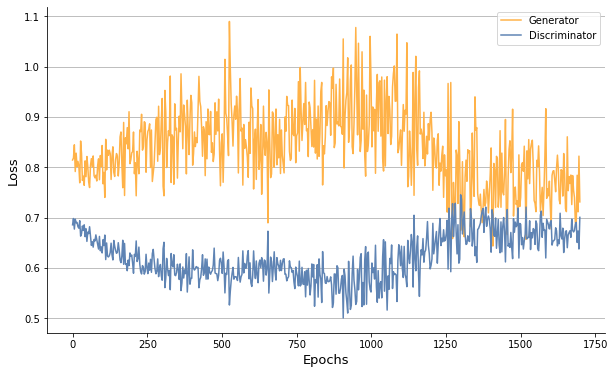

In [23]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
rr = range(0,len(gloss), 3)
short_g_loss = [gloss[i] for i in rr]
short_d_loss = [dloss[i] for i in rr]
#plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(rr, short_g_loss, label="Generator", color="#FFB248")
plt.plot(rr, short_d_loss, label="Discriminator", color="#5F84B4")
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.grid(axis="y")
plt.legend();

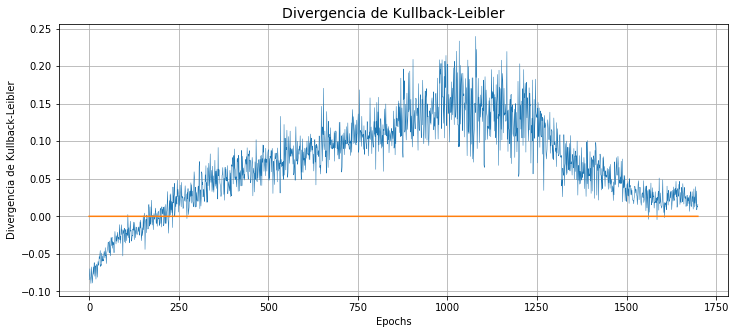

In [24]:
plt.figure(figsize=(12,5))
plt.title("Divergencia de Kullback-Leibler", fontsize=14)
plt.plot(range(len(utils.kl_d)), utils.kl_d, linewidth=.5)
plt.plot(range(len(utils.kl_d)), np.zeros(len(utils.kl_d)))
plt.grid()
plt.xlabel("Epochs");
plt.ylabel("Divergencia de Kullback-Leibler");

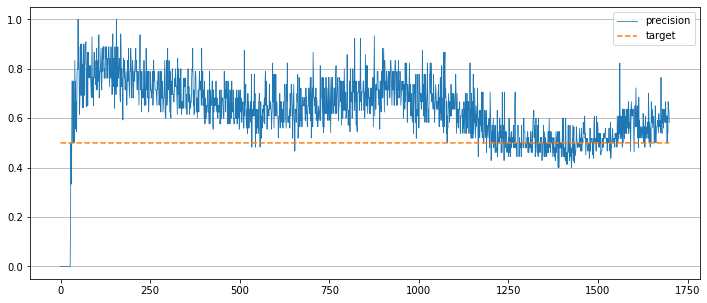

In [25]:
fig = plt.figure(figsize=(12,5))
plt.plot(range(len(utils.precision)), utils.precision, linewidth=.8, label="precision")
plt.grid(axis="y")
plt.plot(range(len(utils.precision)), np.ones(len(utils.precision))*.5, label="target", linestyle="--")
plt.legend();

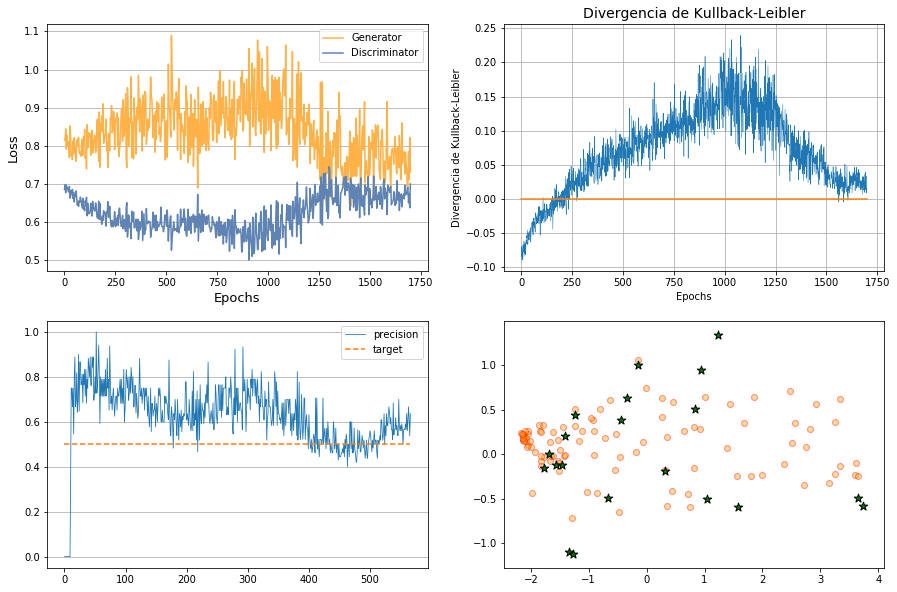

In [26]:
p = utils.plot_results(syn_size=100)